# Отток клиентов

## Подготовка данных

Импортируем все необходимые модели, функции и библиотеки:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Загрузим исходный датасет:

In [4]:
data = pd.read_csv('/Users/mihail/Downloads/data science/project of sprint 10/Churn.csv')

### Проверка признаков на мультиколлинеарность

interval columns not set, guessing: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


/Users/mihail/opt/anaconda3/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Surname is large: 2932. Are you sure this is not an interval variable? Analysis for pairs of variables including Surname can be slow.
  warnings.warn(


<AxesSubplot:>

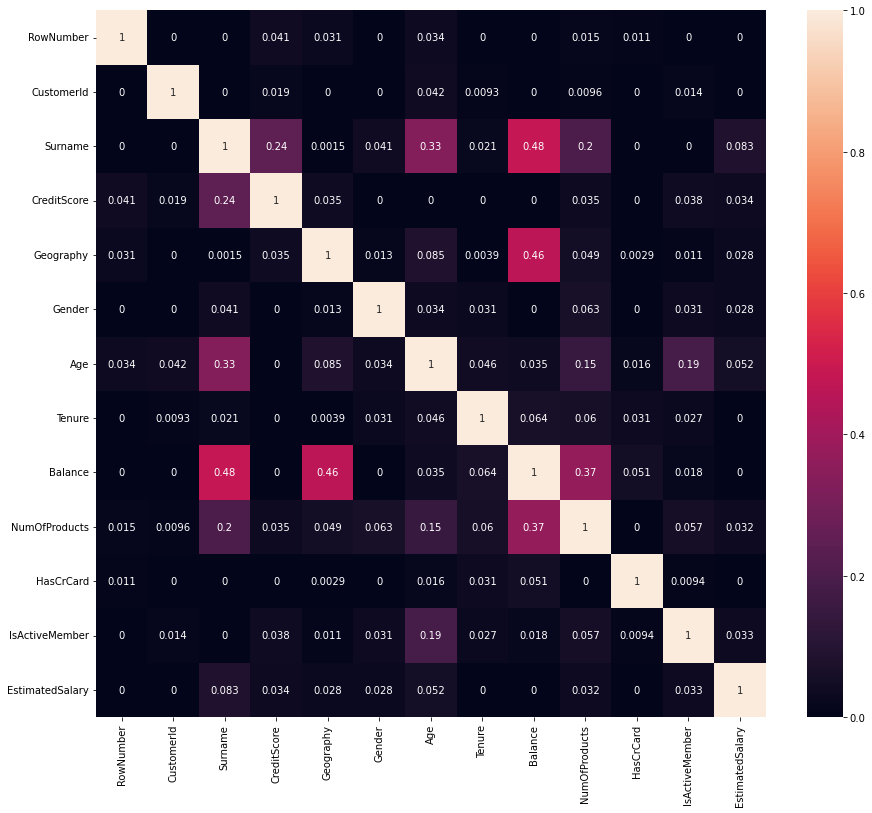

In [5]:
plt.figure(figsize=(15, 13))
sns.heatmap(data.drop('Exited', axis=1).phik_matrix(), annot=True)

Посмотрим размер датафрейма, основную информацию и общий вид данных по первым десяти строкам:

In [6]:
data.shape

(10000, 14)

In [7]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Удаление ненужных данных

В таблице имеются три категориальных признака: Surname,	Geography, Gender.

Столбцы RowNumber и Surname не несут информацию, необходимую для анализа оттока клиентов: первый дублирует индексы, а второй показывает фамилии, которые не нужны, поскольку есть привязка к клиенту по столбцу CustomerId. Поэтому удалим их: 

In [9]:
data = data.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)

Разделим датафрейм на столбцы с целевым признаком - 'Exited' и столбцы с остальными признаками:

In [10]:
features = data.drop('Exited', axis=1)
target = data['Exited']

### Разделение данных на выборки

Разделим полученные массивы на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. 

Сначала выделим тестовую выборку:

In [11]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345 
    #По условию сама по себе доля оттока незначительна
    #от месяца к месяцу, поэтому считаем что дисбаланс постоянен во времени, 
    #поэтому оставим значение shuffle=True.
)

Чтобы сохранить соотношение 3:1:1 для получения валидационной выборки надо взять одну четвертую часть от тренировочной выборки выше:

In [12]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345
)

In [13]:
target_train.mean()

0.20316666666666666

In [14]:
target_valid.mean()

0.1955

In [15]:
target_test.mean()

0.2135

Доли классов целевого признака примерно одинаковы, поэтому параметр stratify не задействуем.

Размеры выборок:

In [16]:
features_test.shape[0] #тестовая выборка

2000

In [17]:
features_train.shape[0] #тренировочная выборка

6000

In [18]:
features_valid.shape[0] #валидационная выборка

2000

### OHE-преобразование категориальных признаков

Преобразуем категориальные признаки в количественные с помощью метода OneHotEncoder:

Для начала сохраним отдельно массив с числовыми признаками:

In [19]:
n = [features_train[i].dtype != 'object' for i in features_train.columns]
features_train_num = features_train[features_train.columns[n]] #выборка train с численными признаками
features_valid_num = features_valid[features_valid.columns[n]] #выборка valid с численными признаками
features_test_num = features_test[features_test.columns[n]] #выборка test с численными признаками

In [28]:
features_train_num

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
492,639,38,4.0,81550.94,2,0,1,118974.77
6655,554,44,NaN,85304.27,1,1,1,58076.52
4287,714,53,1.0,99141.86,1,1,1,72496.05
42,556,61,2.0,117419.35,1,1,1,94153.83
8178,707,46,7.0,127476.73,2,1,1,146011.55
...,...,...,...,...,...,...,...,...
8819,592,36,10.0,123187.51,1,0,1,146111.35
1537,821,28,8.0,0.00,1,1,1,36754.13
1408,707,32,9.0,0.00,2,0,0,30807.02
7661,612,44,2.0,115163.38,1,1,1,97677.52


Массив с категориальными признаками:

In [20]:
n = [features_train[i].dtype == 'object' for i in features_train.columns]
features_train_cat = features_train[features_train.columns[n]] #выборка train с катег. признаками
features_valid_cat = features_valid[features_valid.columns[n]] #выборка valid с катег. признаками
features_test_cat = features_test[features_test.columns[n]] #выборка test с катег. признаками

Создаем объект структуры OneHotEncoder():

In [21]:
ohe = OneHotEncoder(sparse=False, drop='first')

Подгоняем и трансформируем данные:

In [22]:
ohe.fit(features_train_cat)

OneHotEncoder(drop='first', sparse=False)

Преобразуем в датафрейм с исходными индексами:

In [23]:
transformed_train = pd.DataFrame(
    ohe.transform(features_train_cat), index=features_train_cat.index, columns=['0', '1', '2'])
transformed_valid = pd.DataFrame(
    ohe.transform(features_valid_cat), index=features_valid_cat.index, columns=['0', '1', '2'])
transformed_test = pd.DataFrame(
    ohe.transform(features_test_cat), index=features_test_cat.index, columns=['0', '1', '2'])

In [27]:
transformed_train

,0,1,2
492,0.0,0.0,0.0
6655,0.0,0.0,1.0
4287,1.0,0.0,1.0
42,0.0,0.0,0.0
8178,0.0,0.0,0.0
...,...,...,...
8819,1.0,0.0,1.0
1537,0.0,0.0,0.0
1408,0.0,0.0,1.0
7661,1.0,0.0,1.0


### Заполнение пропусков в столбце Tenure

Число пропусков в выборках:

In [32]:
features_train_num['Tenure'].isna().sum()

570

In [33]:
features_valid_num['Tenure'].isna().sum()

173

In [34]:
features_test_num['Tenure'].isna().sum()

166

Столбец Tenure имеет 909 пропусков. Сколько лет человек является клиентом банка - важный признак, восстановим его  медианным заполнением, хотя пропуски составляют лишь 9% от всего объема данных и их можно удалить, наставник посоветовал в DS-задачах заполнять все:

Заполним пропуски методом KNeighborsClassifier

In [35]:
features_neigh_train = features_train_num.query('~Tenure.isna()').drop('Tenure', axis=1) #тренировочная выборка

In [36]:
target_neigh_train = features_train_num.query('~Tenure.isna()')['Tenure'] #целевые значения тренировочной выборки

In [37]:
neigh = KNeighborsClassifier(n_neighbors=10) # создаем объект модели 
neigh.fit(features_neigh_train, target_neigh_train) # обучаем модель

KNeighborsClassifier(n_neighbors=10)

In [38]:
features_neigh_train_na = features_train_num.query(
    'Tenure.isna()').drop('Tenure', axis=1) #выделяем признаки, по которым надо предсказать
predictions_train = neigh.predict(features_neigh_train_na) # формируем предсказания

In [39]:
features_train_num.loc[features_neigh_train_na.index, ['Tenure']] = predictions_train 
#заполняем пропуски предсказаниями

In [40]:
features_neigh_valid_na = features_valid_num.query(
    'Tenure.isna()').drop('Tenure', axis=1) #выделяем признаки, по которым надо предсказать
predictions_valid = neigh.predict(features_neigh_valid_na) # формируем предсказания

In [41]:
features_valid_num.loc[features_neigh_valid_na.index, ['Tenure']] = predictions_valid 
#заполняем пропуски предсказаниями

In [42]:
features_neigh_test_na = features_test_num.query(
    'Tenure.isna()').drop('Tenure', axis=1) #выделяем признаки, по которым надо предсказать
predictions_test = neigh.predict(features_neigh_test_na) # формируем предсказания

In [43]:
features_test_num.loc[features_neigh_test_na.index, ['Tenure']] = predictions_test 
#заполняем пропуски предсказаниями

Но в дальнейшем в финальных выводах я приведу результаты и для случая удаления пропусков.

### Масштабирование числовых признаков

Числовые признаки имеют разный масштаб, поэтому масштабируем их, а затем объединим с трансформированными категориальными:

Создадим объект структуры StandardScaler() и настроим его на обучающих данных:

In [44]:
scaler = StandardScaler()
scaler.fit(features_train_num) 

StandardScaler()

Преобразуем столбцы функцией transform() и преобразуем массивы numpy в датафреймы с сохранением индексов разбиения исходного датасета на выборки:

In [45]:
features_scaled_train = pd.DataFrame(
    scaler.transform(features_train_num), index=features_train_num.index, columns=features_train_num.columns)

features_scaled_valid = pd.DataFrame(
    scaler.transform(features_valid_num), index=features_valid_num.index, columns=features_valid_num.columns)

features_scaled_test = pd.DataFrame(
    scaler.transform(features_test_num), index=features_test_num.index, columns=features_test_num.columns)

Теперь объединим числовые и ohe-признаки:

In [46]:
features_train = pd.concat([features_scaled_train, transformed_train], axis=1)
features_train.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2
492,-0.134048,-0.078068,-0.321849,0.076163,0.816929,-1.550255,0.968496,0.331571,0.0,0.0,0.0
6655,-1.010798,0.494555,0.713405,0.136391,-0.896909,0.645055,0.968496,-0.727858,0.0,0.0,1.0
4287,0.639554,1.353490,-1.357104,0.358435,-0.896909,0.645055,0.968496,-0.477006,1.0,0.0,1.0
42,-0.990168,2.116987,-1.012019,0.651725,-0.896909,0.645055,0.968496,-0.100232,0.0,0.0,0.0
8178,0.567351,0.685430,0.713405,0.813110,0.816929,0.645055,0.968496,0.801922,0.0,0.0,0.0
2127,0.598296,-0.459816,1.403575,0.921963,0.816929,0.645055,-1.032529,0.820416,1.0,0.0,1.0
2051,0.618925,-0.173505,-1.357104,0.482629,0.816929,-1.550255,-1.032529,1.208574,0.0,0.0,0.0
6712,-0.546636,0.399118,-0.321849,-1.232442,-0.896909,0.645055,-1.032529,1.225280,0.0,0.0,0.0
4994,1.485360,1.258053,0.023236,1.450438,-0.896909,0.645055,0.968496,-0.645530,1.0,0.0,0.0
9523,0.082561,-0.650691,-1.702188,0.607589,-0.896909,0.645055,-1.032529,-0.266350,0.0,0.0,0.0


In [47]:
features_valid = pd.concat([features_scaled_valid, transformed_valid], axis=1)
features_valid

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2
2358,0.175393,0.399118,-1.357104,1.385698,-0.896909,-1.550255,0.968496,-1.466761,0.0,0.0,1.0
8463,-1.299609,0.971741,-1.012019,-1.232442,-0.896909,0.645055,-1.032529,0.254415,0.0,1.0,1.0
163,0.711757,-0.268942,-1.012019,-1.232442,0.816929,0.645055,0.968496,0.122863,0.0,1.0,0.0
3074,-0.391916,0.494555,0.368321,0.672529,-0.896909,0.645055,-1.032529,0.585847,1.0,0.0,0.0
5989,0.165078,1.353490,1.748660,0.536522,-0.896909,-1.550255,-1.032529,1.462457,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
207,-0.350657,-0.459816,0.023236,0.933102,-0.896909,0.645055,0.968496,0.905307,0.0,0.0,1.0
8746,0.082561,-0.459816,1.058490,0.476293,0.816929,-1.550255,0.968496,1.432571,0.0,0.0,1.0
1809,-0.134048,1.067178,0.368321,0.618283,0.816929,0.645055,0.968496,-0.813904,0.0,0.0,0.0
5919,-0.072160,0.971741,1.058490,-1.232442,0.816929,0.645055,-1.032529,1.080287,0.0,1.0,1.0


In [48]:
features_test = pd.concat([features_scaled_test, transformed_test], axis=1)
features_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,0,1,2
7867,-0.123733,0.685430,-0.666934,-1.232442,-0.896909,0.645055,0.968496,0.980212,0.0,1.0,0.0
1402,1.083087,-0.937002,1.058490,0.858518,-0.896909,0.645055,-1.032529,-0.390486,0.0,0.0,1.0
8606,1.598822,0.303681,0.023236,-1.232442,0.816929,0.645055,0.968496,-0.435169,0.0,1.0,1.0
8885,0.165078,0.589993,-0.321849,0.412100,0.816929,0.645055,0.968496,1.017079,0.0,1.0,1.0
6494,0.484834,-1.032439,0.713405,-1.232442,0.816929,0.645055,0.968496,-1.343558,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2563,1.970151,-1.127876,0.023236,-1.232442,0.816929,0.645055,0.968496,-0.564021,0.0,0.0,0.0
1167,-1.072686,-0.364379,1.748660,-1.232442,-0.896909,0.645055,0.968496,-1.193686,0.0,0.0,0.0
1009,-0.020586,3.071359,-1.702188,-1.232442,-0.896909,0.645055,0.968496,1.312849,0.0,1.0,1.0
1002,0.753016,0.017370,-1.357104,-0.415981,0.816929,0.645055,0.968496,1.463205,1.0,0.0,1.0


Но в дальнейшем в финальных выводах я приведу результаты и для случая удаления.

Проверим на мультиколлинеарность сформированный обучающий набор признаков:

interval columns not set, guessing: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', '0', '1', '2']


<AxesSubplot:>

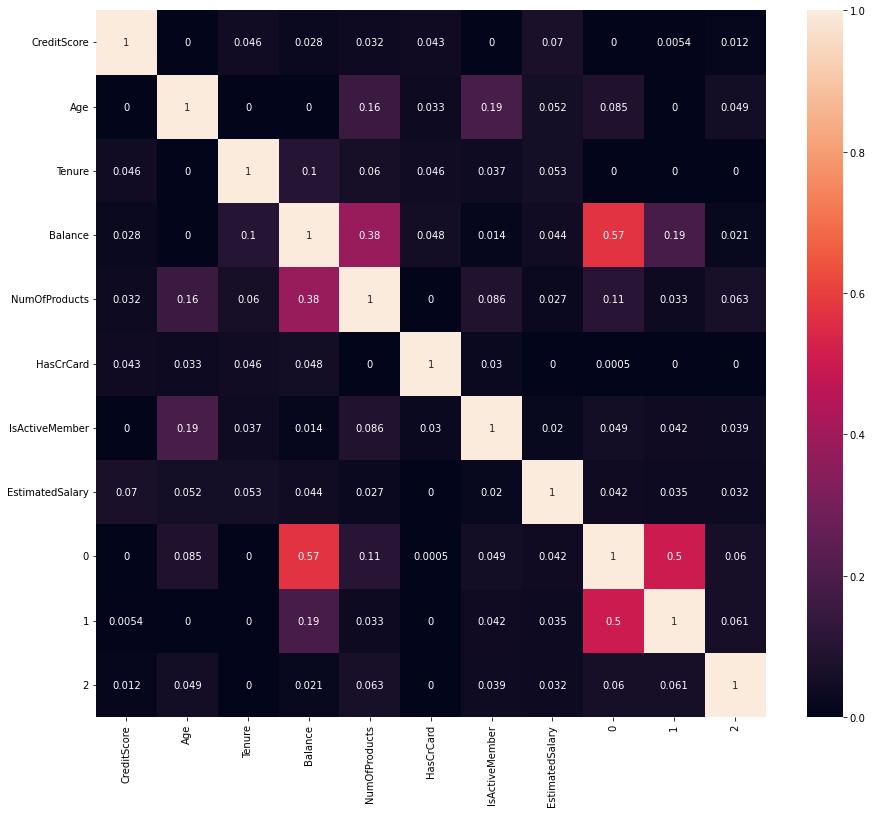

In [49]:
plt.figure(figsize=(15, 13))
sns.heatmap(features_train.phik_matrix(), annot=True)

Все в норме.

### Выводы по шагу 1

При подготовке данных выполнили следующие этапы:
1. Подключили необходимые библиотеки, функции и модели. Изучили исходный датафрейм. Провели проверку на мультиколлинеарность для исходных признаков и для подготовленной тренировочной выборки с помощью библиотеки phik.
2. Удалили ненужные столбцы Surname, Rownumber и CustomerId. 
3. Разделили данные на столбцы с целевым и остальными признаками и создали обучающую, валидационную и тестовую выборки в соотношении 3:1:1.
5. Преобразовали категориальные признаки Geography и Gender в количественные с помощью метода OHE.
6. Заполнили 909 пропусков в столбце Tenure методом классификации kneighborsclassifier.
7. Масштабировали нецелевые числовые признаки.
8. Сформировали обработанные обучающую, валидационную и тестовую выборки для исследования: объединили соответствующие им числовые и категориальные признаки.

## Исследование задачи

### Исследование баланса классов

Посчитаем долю каждого из значений целевого признака. Поскольку в целевом признаке 2 значения 0 и 1 используем mean() для оценки доли положительного класса:

In [50]:
data['Exited'].mean()

0.2037

На дисбаланс классов могут влиять дубликаты, проверим их наличие:

In [51]:
data.query('Exited==0').duplicated().sum()

0

Полных дубликатов не выялено. 
Также ошибки в размечивании классов целевого признака мы исключаем, поэтому можно судить о дисбалансе классов целевого признака в соотношении 4:1.

Для оценки качества моделей будем использовать метрики f1-мера и auc_roc.

### Обучение моделей с учетом дисбаланса классов

Решающее дерево

In [52]:
best_f1 = 0

for depth in range(1, 20, 1):

    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
   
    if f1 > best_f1:
        
        best_f1 = f1
        best_model = model
        
        probabilities_valid = best_model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

best_f1, auc_roc, best_model #наибольшее значение метрики f1, метрика auc_roc 
                            #и параметры модели с наибольшим значением метрики f1

(0.5520504731861199,
 0.8281207529894979,
 DecisionTreeClassifier(max_depth=7, random_state=12345))

Для разнообразия подберем параметры модели с помощью GridSearchCV:

In [53]:
parametrs = { 'max_depth': range (1, 20, 1),
              'random_state': [12345]
            }

In [54]:
model = DecisionTreeClassifier()

In [55]:
GSCV = GridSearchCV(model, parametrs, cv = 5, scoring = 'f1')

In [57]:
GSCV.fit(features_train,target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 20), 'random_state': [12345]},
             scoring='f1')

In [ ]:
GSCV.best_params_

In [ ]:
GSCV.best_score_

Метрика auc_roc при этом равна 0.82. Что говорит о хорошем качестве модели. Как так?

Обе метрики f1 и auc_roc хорошо оценивают производительность классификатора. Их разница проявляется, когда классы несбалансированы, то есть когда количество выборок в положительном классе очень мало по сравнению с отрицательным классом, как в нашем случае (4:1). Классификатор (ошибочно) предсказывает много выборок из отрицательного класса в положительный класс, значение Precision небольшое, но FPR все равно большое. В результате PR-кривая правильно показывает недостаток производительности по сравнению с AUC. 

Случайный лес

In [ ]:
best_f1 = 0

for depth in range(1, 14, 3):

    for est in range(10, 91, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
    
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)

        if f1 > best_f1:
            best_f1 = f1
            best_model = model
        
best_f1, auc_roc, best_model, est #наибольшее значение метрики f1, метрика auc_roc 
                            #и параметры модели с наибольшим значением метрики f1

Для разнообразия подберем параметры модели с помощью GridSearchCV:

In [ ]:
parametrs = { 'max_depth': range(1, 14, 3),
              'n_estimators': range(10, 91, 10)
            }

In [ ]:
model = RandomForestClassifier()

In [ ]:
GSCV = GridSearchCV(model, parametrs, cv = 5, scoring = 'f1')

In [ ]:
%%time
GSCV.fit(features_train,target_train)

In [ ]:
GSCV.best_params_

In [ ]:
GSCV.best_score_ #f1-мера

Логрегрессия

In [ ]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

f1, auc_roc

Для разнообразия подберем параметры модели с помощью GridSearchCV:

In [ ]:
parametrs = { 'max_iter': range(100, 500, 10100)}

In [ ]:
model = LogisticRegression(random_state=12345)

In [ ]:
GSCV = GridSearchCV(model, parametrs, cv = 5, scoring = 'f1')

In [ ]:
GSCV.fit(features_train,target_train)

In [ ]:
GSCV.best_params_

In [ ]:
GSCV.best_score_

### Выводы по шагу 2

В датасете наблюдается дисбаланс по классам целевого признака 4:1 в пользу нулевых значений.

В данном случае наиболее показательной агрегационной метрикой является f1-мера. 

Наилучшее значение метрики f1 = 0.58 соответствует модели RandomForestClassifier('max_depth'=17, 'n_estimators'=50, 'random_state'=12345).

## Борьба с дисбалансом

### Взвешивание классов

Добавим гиперпараметр class_weight='balanced'. 

Решающее дерево со взвешиванием классов:

In [ ]:
parametrs = { 'max_depth': range (1, 16, 1)}

In [ ]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=12345)

In [ ]:
GSCV = GridSearchCV(model, parametrs, return_train_score=True, cv = 5, scoring = 'f1')

In [ ]:
GSCV.fit(features_train,target_train)

In [ ]:
GSCV.best_params_

In [ ]:
GSCV.best_score_

Случайный лес со взвешиванием классов:

In [ ]:
parametrs = { 'max_depth': range(1, 14, 3),
              'n_estimators': range(10, 91, 10)
            }

In [ ]:
model = RandomForestClassifier(class_weight='balanced', random_state=12345)

In [ ]:
GSCV = GridSearchCV(model, parametrs, cv = 5, scoring = 'f1')

In [ ]:
GSCV.fit(features_train,target_train)

In [ ]:
GSCV.best_params_

In [ ]:
GSCV.best_score_

Логистическая регрессия со взвешиванием классов:

In [ ]:
parametrs = {'max_iter': range(100, 500, 10100)}

In [ ]:
model = LogisticRegression(class_weight='balanced', random_state=12345)

In [ ]:
GSCV = GridSearchCV(model, parametrs, cv = 5, scoring = 'f1')

In [ ]:
GSCV.fit(features_train,target_train)

In [ ]:
GSCV.best_params_

In [ ]:
GSCV.best_score_

### Семплинг

Напишем функции для Upsampling и Downsampling:

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Решающее дерево c upsampling

In [ ]:
best_f1 = 0

for depth in range(1, 20, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)

    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        
best_f1, auc_roc, best_model #наибольшее значение метрики f1, метрика auc_roc 
                            #и параметры модели с наибольшим значением метрики f1

Решающее дерево c downsampling

In [ ]:
best_f1 = 0

for depth in range(1, 20, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)

    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        
best_f1, auc_roc, best_model  #наибольшее значение метрики f1, метрика auc_roc 
                            #и параметры модели с наибольшим значением метрики f1

Случайный лес c upsampling

In [ ]:
best_f1 = 0

for depth in range(1, 14, 3):

    for est in range(10, 121, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_upsampled, target_upsampled)
    
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)

        if f1 > best_f1:
            best_f1 = f1
            best_model = model
        
best_f1, auc_roc, best_model  #наибольшее значение метрики f1, метрика auc_roc 
                            #и параметры модели с наибольшим значением метрики f1

Случайный лес c downsampling

In [ ]:
best_f1 = 0

for depth in range(1, 14, 3):

    for est in range(10, 121, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_downsampled, target_downsampled)
    
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)

        if f1 > best_f1:
            best_f1 = f1
            best_model = model
        
best_f1, auc_roc, best_model  #наибольшее значение метрики f1, метрика auc_roc 
                            #и параметры модели с наибольшим значением метрики f1

Логистическая регрессия c upsampling

In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
f1, auc_roc

Логистическая регрессия c downsampling

In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
f1, auc_roc

Значение f1-меры больше для upsampling для моделей случайный лес и решающее дерево, что можно обусловить обучением моделей на большей выборке по сравнению с downsampling.

### Изменение порога

Решающее дерево со взвешиванием классов:

In [ ]:
model = DecisionTreeClassifier(class_weight='balanced', random_state=12345, max_depth=6)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

f1 = 0
t = 0
for threshold in np.arange(0, 0.8, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    f1_measure = f1_score(target_valid, predicted_valid)
    if f1_measure > f1:
        f1 = f1_measure
        t = threshold
f1, t, auc_roc

Решающее дерево с upsampling:

In [ ]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

f1 = 0
t = 0
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1_measure = f1_score(target_valid, predicted_valid)
    if f1_measure > f1:
        f1 = f1_measure
        t = threshold
f1, t, auc_roc

Случайный лес со взвешиванием классов:

In [ ]:
model = RandomForestClassifier(class_weight='balanced', random_state=12345, max_depth=10, n_estimators=80)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

f1 = 0
t = 0
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1_measure = f1_score(target_valid, predicted_valid)
    if f1_measure > f1:
        f1 = f1_measure
        t = threshold
f1, t, auc_roc

Случайный лес с upsampling:

In [ ]:
model = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=90)
model.fit(features_upsampled, target_upsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

f1 = 0
t = 0
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1_measure = f1_score(target_valid, predicted_valid)
    if f1_measure > f1:
        f1 = f1_measure
        t = threshold
f1, t, auc_roc

Логрегрессия со взвешиванием классов:

In [ ]:
model = LogisticRegression(class_weight='balanced', random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

f1 = 0
t = 0
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1_measure = f1_score(target_valid, predicted_valid)
    if f1_measure > f1:
        f1 = f1_measure
        t = threshold
f1, t, auc_roc

Логрегрессия с downsampling:

In [ ]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_downsampled, target_downsampled)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

f1 = 0
t = 0
for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1_measure = f1_score(target_valid, predicted_valid)
    if f1_measure > f1:
        f1 = f1_measure
        t = threshold
f1, t, auc_roc

### Выводы по шагу 3

Для борьбы с дисбалансом использовались три способа: взвешивание классов - задание гиперпараметра class_weight='balanced', семплинг - Upsampling и downsampling и изменение порога.

Исследовано три типа моделей: решающее дерево, случайный лес и логистическая регрессия.

Использование взвешивания и семплинга одновременно не приводило к улучшению метрики f1. Существенное влияние на значение метрики f1 оказывал непосредственно выбор самой модели.

По результатам исследования выбрана модель случайного леса: RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=90) с upsampling и порогом 0.5.
Значение f1-меры = 0.6. Значение AUC-ROC = 0.85.

Значение AUC-ROC не зависит от техник исправления дисбаланса. Функция AUC-ROC устроена не в виде суммы ошибок на объектах, а в виде суммы ошибок на парах объектов разных классов. При любой балансировке показатели TPR и FPR будут сохраняться примерно теми же.

## Тестирование модели

In [ ]:
threshold = 0.5
model = RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=90)
model.fit(features_upsampled, target_upsampled)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

predicted_test = probabilities_one_test > threshold
f1 = f1_score(target_test, predicted_test)

f1, auc_roc

### Выводы по шагу 4

Тестирование модели RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=90) с upsampling и порогом 0.5 показало более лучший результат по сравнению с валидационной выборкой: f1 = 0.63 против f1 = 0.6.

Цель достигнута: метрика f1 > 0.59.

Также смоделировал случай при удалении пропусков в столбце Tenure: была достигнута f1=0.62 (модель RandomForestClassifier(class_weight='balanced', random_state=12345, max_depth=7, n_estimators=110) со взвешиванием без upsampling и порогом 0.52) - что тоже неплохо на мой взгляд.

## Общий вывод:

**Целью проекта** являлось прогнозирование оттока клиентов с метрикой f1 > 0.59.

**Для этого на первом этапе проведена подготовка данных:**
   - с помощью матрицы phik провеедена оценка мультиколлинерности категориальных и количнственных признаков на начальном этапе и после формирования обучающей выборки;
   - удалены столбцы с неинформативными. признаками;
   - данные разделены по целевому и нецелевому признакам и затем на обучающий, валидационный и тестовый наборы выборок;
   - выполнено кодирование категориальных нецелевых признаков методом OHE;
   - заполнены пропуски в столбце Tenure с помощью модели NeiboursClassifier;
   - после масштабированы все числовые признаки и сформированы итоговые выборки нецелевых признаков.
    
**На втором этапе:** 
- в ходе исследования баланса классов выявлен дисбаланс 4:1;
- исследованы модели с дисбалансом (решающее дерево, случайный лес и логрессия), лучший результат достигнут с помощью алгоритма gridsearchCV - это модель RandomForestClassifier(max_depth=13, n_estimators=50, random_state=12345), метрика f1 =0.58.

**На третьем этапе исследованы методы борьбы с дисбалансом классов:**
- использовались три способа: взвешивание классов - задание гиперпараметра class_weight='balanced', семплинг upsampling и downsampling и изменение порога;
- использование взвешивания и семплинга одновременно не приводило к улучшению метрики f1. Существенное влияние на значение метрики f1 оказывал непосредственно выбор самой модели;
- выбрана модель случайного леса: RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=90) со взвешиванием классов и порогом 0.5. Значение f1-меры = 0.6. Значение AUC-ROC = 0.85.
- значение AUC-ROC не зависит от техник исправления дисбаланса. Функция AUC-ROC устроена не в виде суммы ошибок на объектах, а в виде суммы ошибок на парах объектов разных классов. При любой балансировке показатели TPR и FPR будут сохраняться примерно теми же.

**На четвертом этапе проводилось тестирование выбранной модели**
- тестирование модели RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=90) с upsampling и порогом 0.5 показало более лучший результат по сравнению с валидационной выборкой: f1 = 0.63 против f1 = 0.6.

Таким образом, цель проекта является достигнутой: в ходе исследования выбрана модель прогнозирования оттока клиентов банка RandomForestClassifier(random_state=12345, max_depth=13, n_estimators=90) с upsampling и порогом 0.5 с метрикой f1 = 0.63.